In [1]:
import os
import numpy as np
from astropy.cosmology import Planck15 as cosmo
from astrotog import functions as afunc
from astrotog import classes as aclasses
from astrotog import top_level_classes as atopclass
from mpi4py import MPI
import multiprocessing as mp
from itertools import repeat
import datetime
import time
from copy import copy, deepcopy
import pandas as pd
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
# Set seed for reproduceability
np.random.seed(12345)

/Users/cnsetzer/miniconda3/envs/astrotog/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/cnsetzer/miniconda3/envs/astrotog/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
check_transient= atopclass.rosswog_kilonovae(mej=0.05,vej=0.05,kappa=1.0)
check_transient2= atopclass.rosswog_numerical_kilonovae('/Users/cnsetzer/Documents/LSST/sedb/rosswog/NSNS/winds/SED_wind4.dat', singleSED=True)
check_transient3= atopclass.rosswog_numerical_kilonovae('/Users/cnsetzer/Documents/LSST/pintoeastman_macronovae/RUN/mne-SED.dat', singleSED=True)

In [3]:
plot_flux = []
for i in range(len(check_transient.phase)):
    plot_flux.append(sum(check_transient.flux[i]))
plot_flux2 = []
for i in range(len(check_transient2.phase)):
    plot_flux2.append(sum(check_transient2.flux[i]))
plot_flux3 = []
for i in range(len(check_transient3.phase)):
    plot_flux3.append(sum(check_transient3.flux[i]))

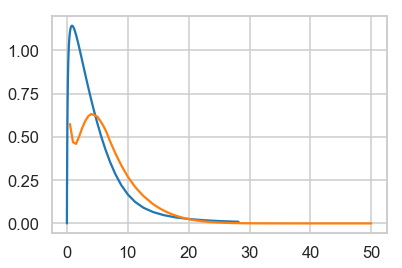

In [4]:
plt.plot(check_transient.phase, plot_flux)
plt.plot(check_transient2.phase, plot_flux2)
plt.plot(check_transient3.phase, plot_flux3)